In [2]:
import numpy as np
import pandas as pd
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from tqdm import tqdm
import scipy
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import seaborn as sns
from PIL import Image
%matplotlib inline
#############
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
#######################
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import MultiStepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#WBC Blood Cell Classification:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

## Visualize One Example the Annotated Picture

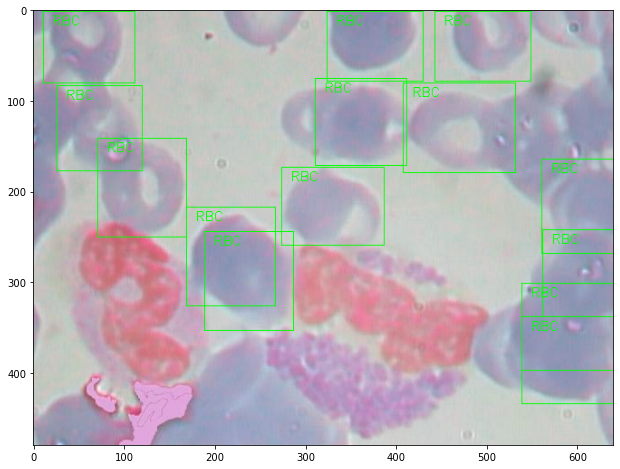

In [5]:
#WBC Blood Cell Classification:
image = cv2.imread("data/dataset-master/dataset-master/JPEGImages/BloodImage_00010.jpg")
tree = ET.parse("data/dataset-master/dataset-master/Annotations/BloodImage_00010.xml")
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        ymin = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        xmax = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        ymax = int(round(float(dim.text)))
                if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), 1)
plt.figure(figsize=(16,8))
plt.imshow(image)
plt.show()

# Visualize the random samples of each WBC cell type 

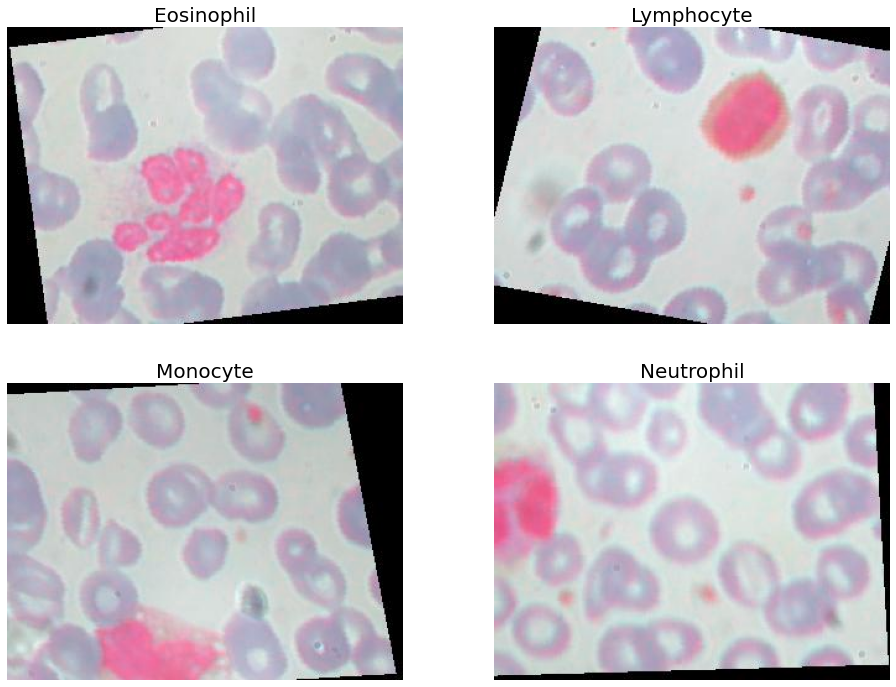

In [6]:
# Plot Image
def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    return
image_name = 'data/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(16,12))
plt.subplot(221)
plt.title('Eosinophil',fontsize = 20)
plt.axis('off') 
plotImage(image_name)
image_name = 'data/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte',fontsize = 20)
plt.axis('off') 
plotImage(image_name)
image_name = 'data/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte',fontsize = 20)
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = 'data/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil',fontsize = 20)
plt.axis('off') 
plotImage(image_name)

## Original Data is unbalanced among different cell types (classes)

[  3  88  33  21 207]


C:\Users\parshinshojaee\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'Counts')

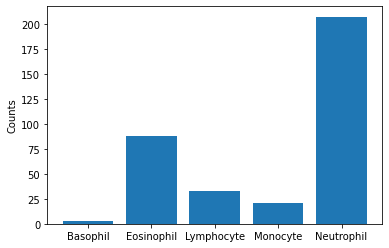

In [7]:
reader = csv.reader(open('data/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
X3 = []
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
# print( encoded_y, len(y3) )
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

## Augmented data (rotated, zoom-in + zoom-out, random crop, etc.) to make it balanced

In [8]:
from tqdm import tqdm
def get_data(folder):
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
#                     img_file = Image.fromarray(img_file).resize(size=(60,80,3))
#                     img_file = resize(img_file, (60,80,3))
                    img_file = resize(img_file, (120,160,3)) #reduce the size of the picture
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

X_train, y_train, z_train = get_data('data/dataset2-master/dataset2-master/images/TRAIN/')

100%|██████████████████████████████████████████████████████████████████████████████| 2499/2499 [01:00<00:00, 41.64it/s]


In [9]:
X_test, y_test, z_test = get_data('data/dataset2-master/dataset2-master/images/TEST/')

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:04<00:00, 126.11it/s]


C:\Users\parshinshojaee\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


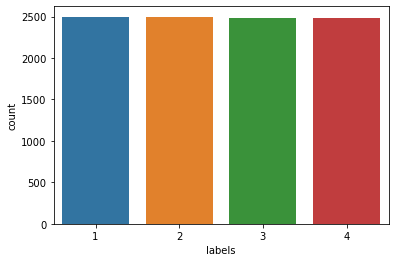

In [10]:
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [201]:
# # Covert Augmented Data to Torch
# X_train_torch = torch.from_numpy(X_train)
# X_train_torch = X_train_torch.reshape((X_train_torch.shape[0], 3,X_train_torch.shape[1],X_train_torch.shape[2]))
# y_train_torch = torch.from_numpy(y_train-1)
# z_train_torch = torch.from_numpy(z_train)

# X_test_torch = torch.from_numpy(X_test)
# X_test_torch = X_test_torch.reshape((X_test_torch.shape[0],3,X_test_torch.shape[1],X_test_torch.shape[2]))
# y_test_torch = torch.from_numpy(y_test-1)
# z_test_torch = torch.from_numpy(z_test)

# trainset_y = TensorDataset(X_train_torch, y_train_torch)
# trainset_z = TensorDataset(X_train_torch, z_train_torch)
# testset_y = TensorDataset(X_test_torch, y_test_torch)
# testset_z = TensorDataset(X_test_torch, z_test_torch)

# #Torch Data Loader:
# train_minibatch_size = 128
# test_minibatch_size = 512
# train_loader = DataLoader(trainset_y, batch_size = train_minibatch_size, shuffle = True)
# test_loader = DataLoader(testset_y, batch_size = test_minibatch_size, shuffle = True)

In [11]:
class BloodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.images[idx]), self.labels[idx]
        return self.images[idx], self.labels[idx]

In [12]:
tfms = transforms.Compose([transforms.ToTensor()])
train = BloodDataset(X_train, y_train-1, transform=tfms)
#normalize the input data
mean = tuple((X_train.mean(axis=(0,1,2))/255).round(4))
std = tuple((X_train.std(axis=(0,1,2))/255).round(4))
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean, std)])
train = BloodDataset(X_train, y_train-1, transform=tfms)
#####################################
tfms = transforms.Compose([transforms.ToTensor()])
test = BloodDataset(X_test, y_test-1, transform=tfms)
mean = tuple((X_test.std(axis=(0,1,2))/255).round(4))
std = tuple((X_test.std(axis=(0,1,2))/255).round(4))
tfms = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean, std)])
test = BloodDataset(X_test, y_test-1, transform=tfms)
##################################
batch_size = 128
test_size = 128
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=test_size, shuffle=False)

# Task2 : Classification of different cell types

In [13]:
#Train Function:
def train(epoch, model, train_loader):
    model.train()
    
    train_nb_batch = len(train_loader)
    train_loss = 0.0
    train_batch_loss = 0.0
    train_total_loss = 0.0
    train_acc = 0.0
    train_batch_acc = 0.0
    train_total_acc = 0.0
    ####################################
    for i, (minibatch_X, minibatch_y) in enumerate(train_loader):
        minibatch_X = minibatch_X.float().to(device)
        minibatch_y = minibatch_y.long().to(device)
        #zero that gradients buffer
        optimizer.zero_grad()
        #forward + backward + optimize
        outputs = model(minibatch_X)
        loss = criterion(outputs, minibatch_y)
        loss.backward()
        optimizer.step()

        train_batch_loss = loss.item()
        train_total_loss += train_batch_loss
        pred_batch_train = outputs.data.max(1, keepdim=True)[1]
        if i == 0 :
            pred_train = pred_batch_train
        if i >0:
            pred_train = torch.cat([pred_train, pred_batch_train], dim=0)
        train_batch_acc = accuracy_score(pred_batch_train,minibatch_y)
        train_total_acc += train_batch_acc
        
    train_loss = train_total_loss/train_nb_batch
    train_acc = train_total_acc/train_nb_batch
#     scheduler.step()
    return pred_train, train_loss, train_acc

In [14]:
def test(epoch, model, test_loader):
    model.eval()
    
    test_nb_batch = len(test_loader)
    test_loss = 0.0
    test_batch_loss = 0.0
    test_total_loss = 0.0
    test_acc = 0.0
    test_batch_acc = 0.0
    test_total_acc = 0.0
    ####################################
    for i, (minibatch_X, minibatch_y) in enumerate(test_loader):
        minibatch_X = minibatch_X.float().to(device)
        minibatch_y = minibatch_y.long().to(device)
        outputs = model(minibatch_X)
        loss = criterion(outputs, minibatch_y)
        test_batch_loss = loss.item()
        test_total_loss += test_batch_loss
        pred_batch_test = outputs.data.max(1, keepdim=True)[1]
        if i == 0 :
            pred_test = pred_batch_test
        if i >0:
            pred_test = torch.cat([pred_test, pred_batch_test], dim=0)
        test_batch_acc = accuracy_score(pred_batch_test,minibatch_y)
        test_total_acc += test_batch_acc
    test_loss = test_total_loss/test_nb_batch
    test_acc = test_total_acc/test_nb_batch
    return pred_test, test_loss, test_acc

### Customized Architecture:

In [53]:
#Customized CNN Architecture:
class CNN_Arch1(nn.Module):
    def __init__(self, n_classes):
        super(CNN_Arch1, self).__init__()
        self.conv_layer1 = nn.Sequential(
            #Conv Block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_layer2 = nn.Sequential(
            #Conv Block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2) )
        self.conv_layer3 = nn.Sequential(
            #Conv Block 3
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2) )
#         self.conv_layer4 = nn.Sequential(
#             #Conv Block 3
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout(0.2) )
        self.fc_layer = nn.Sequential(
            nn.Linear(14976, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
#             nn.Linear(64, 32),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.2),
            nn.Linear(32,  n_classes))
        
    def forward(self, x):
#         x = F.pad(x, (0, 0, 1, 2)) # [left, right, top, bot]
        h1 = self.conv_layer1(x)
#         h3 = h1
#         h1 = F.pad(h1, (0, 0, 1, 2)) # [left, right, top, bot]
        h2 = self.conv_layer2(h1)
#         h2 = F.pad(h2, (0, 0, 1, 2)) # [left, right, top, bot]
        h3 = self.conv_layer3(h2)
#         h4 = self.conv_layer4(h3)
        h5 = h3.view(h3.size(0), -1)
        h6 = self.fc_layer(h5)
        return h6

In [54]:
n_classes = 4
model = CNN_Arch1(n_classes)
pytorch_total_params = sum(p.numel() for p in model.parameters())
model = model.to(device)
print("Total number of parametrs:",pytorch_total_params)
criterion = nn.CrossEntropyLoss()
lr = 0.0001
# optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.Adadelta(model.parameters(), lr=lr)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
scheduler = MultiStepLR(optimizer, milestones=[5,10,20,40,60,80], gamma=0.5)


Total number of parametrs: 536036


In [55]:
num_epoch = 20
train_losses = []
test_losses = []
train_accs = []
test_accs= []

for epoch in range(num_epoch):
    pred_train, train_loss, train_acc = train(epoch, model, train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    pred_test, test_loss, test_acc = test(epoch, model, test_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print("epoch:",epoch,"train loss:", train_loss, "train accuracy:", train_acc)
    print("epoch:",epoch,"test loss:", test_loss, "test accuracy:", test_acc)

epoch: 0 train loss: 1.310686971896734 train accuracy: 0.35049048775069813
epoch: 0 test loss: 1.2232726514339447 test accuracy: 0.4515411931818182
epoch: 1 train loss: 1.0531655840384655 train accuracy: 0.5253246779004823
epoch: 1 test loss: 1.1158862709999084 test accuracy: 0.45894886363636367
epoch: 2 train loss: 0.9023207945701404 train accuracy: 0.6042579017517137
epoch: 2 test loss: 0.90765610486269 test accuracy: 0.621328125
epoch: 3 train loss: 0.7662084110272236 train accuracy: 0.6843266057374968
epoch: 3 test loss: 0.9118773341178894 test accuracy: 0.5610369318181818
epoch: 4 train loss: 0.6730789748521951 train accuracy: 0.7214255680375731
epoch: 4 test loss: 0.8594314023852349 test accuracy: 0.5883735795454546
epoch: 5 train loss: 0.5835039741717852 train accuracy: 0.7634730420157401
epoch: 5 test loss: 0.6331300780177116 test accuracy: 0.7609730113636364
epoch: 6 train loss: 0.5137613251423224 train accuracy: 0.7926732276593044
epoch: 6 test loss: 0.8337439239025116 test a

In [417]:
print('Finished Training')
PATH = './Project_Task2_Arch1_20epoch_lr0001_dropout.pkl'
torch.save(model, PATH)

Finished Training


In [65]:
np.save('train_losses_Arch1_20epoch_dropout.npy', train_losses)
np.save('train_accs_Arch1_20epoch_dropout.npy', train_accs)
np.save('test_losses_Arch1_20epoch_dropout.npy', test_losses)
np.save('test_accs_Arch1_20epoch_dropout.npy', test_accs)

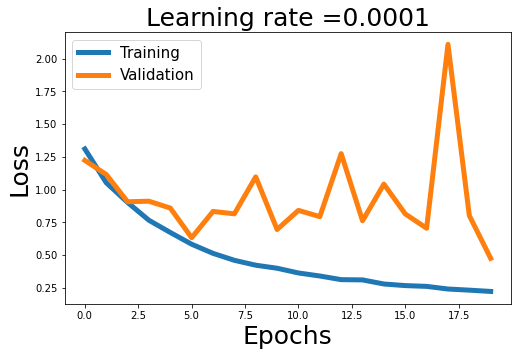

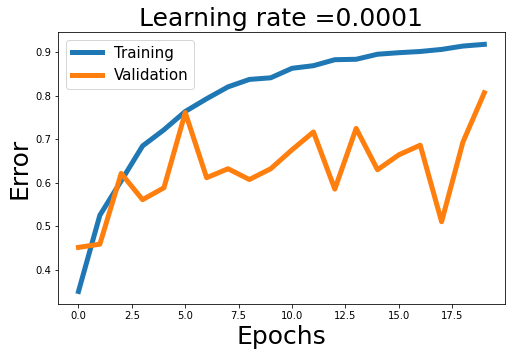

In [64]:
#Plot Train and Validation Loss 
def reject_outliers(data, m):
    return data[ abs(data - np.mean(data)) < m * np.std(data)]

# train_losses2 = reject_outliers(train_losses,m=6)
# test_losses2 = reject_outliers(test_losses,m=6)
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_losses[:])),train_losses[:], label='Training', linewidth=5)
plt.plot(np.arange(len(test_losses[:])),test_losses[:], label='Validation', linewidth=5)
plt.legend(fontsize=15)
plt.ylabel('Loss',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
plt.title("Learning rate =" + str(0.0001),fontsize=25)
plt.savefig('./Task2_Arch1_loss.png')
plt.show() 

#Plot Train and Validation Errors
# train_accs2 = reject_outliers(train_accs)
# test_accs2 = reject_outliers(test_accs)
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_accs[:])),train_accs[:], label='Training', linewidth=5)
plt.plot(np.arange(len(test_accs[:])),test_accs[:], label='Validation', linewidth=5)
plt.legend(fontsize=15)
plt.ylabel('Error',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
plt.title("Learning rate =" + str(0.0001),fontsize=25)
plt.savefig('./Task2_Arch1_error.png')
plt.show() 

# Feature Maps:

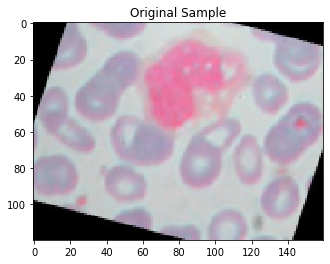

(120, 160, 3)
(3, 120, 160)
torch.Size([1, 3, 120, 160])
(1, 32, 59, 79)


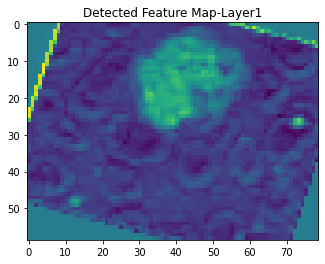

In [89]:
#select a random image sample
n_samples = len(X_test)
random_index = int(np.random.random()*n_samples)
random_sample = X_test[random_index]
plt.imshow(random_sample, interpolation='none')
plt.title("Original Sample")
plt.show()

print(random_sample.shape)
random_sample = np.transpose(random_sample, (2, 0, 1))
print(random_sample.shape)

X_sample = torch.from_numpy(random_sample)
X_sample = X_sample.unsqueeze(0)
print(X_sample.shape)
feature_layer1 = model.conv_layer1(X_sample.float())
# feature_layer2 = model.conv_layer2(feature_layer1)
# feature_layer3 = model.conv_layer3(feature_layer2)
feature_layer1 = feature_layer1.detach().numpy()
# feature_layer2 = feature_layer2.detach().numpy()
# feature_layer3 = feature_layer3.detach().numpy()

print(feature_layer1.shape)
plt.imshow(np.transpose(feature_layer1[:,4,:,:], (1, 2, 0)), interpolation='none')
plt.title("Detected Feature Map-Layer1")
plt.show()
# plt.imshow(np.transpose(feature_layer2[:,4,:,:], (1, 2, 0)), interpolation='none')
# plt.title("Detected Feature Map-Layer2")
# plt.show()
# plt.imshow(np.transpose(feature_layer3[:,3,:,:], (1, 2, 0)), interpolation='none')
# plt.title("Detected Feature Map-Layer3")
# plt.show()

# Confusion Matrix

In [90]:
X_test_trans = np.transpose(X_test, (0,3, 1, 2))
X_test_torch = torch.from_numpy(X_test_trans)
y_test_torch = torch.from_numpy(y_test)
predictions = model(X_test_torch.float())
print(X_test_torch.shape, y_test_torch.shape, predictions.shape)

torch.Size([2487, 3, 120, 160]) torch.Size([2487]) torch.Size([2487, 4])


In [ ]:
print(set(y_test))
conf_matrix = confusion_matrix(y_test-1, np.argmax(predictions.detach().numpy(), 1))
confusion_df = pd.DataFrame(conf_matrix)
##########################
dict_characters = {0:'NEUTROPHIL',1:'EOSINOPHIL',2:'MONOCYTE',3:'LYMPHOCYTE'}
#############################
confusion_df = confusion_df.rename(columns=dict_characters)
confusion_df.index = confusion_df.columns
#############################
#Plot Confusion Matrix
plt.figure(figsize= (20,12))
sns.set(font_scale = 2);
ax = sns.heatmap(confusion_df, annot=True,fmt='g', cbar = True, cmap=sns.cubehelix_palette(50));
# heatR = sns.heatmap(confusion_df , annot =True , fmt='g', cbar = True, linewidths=2, cmap= 'coolwarm')
ax.set(xlabel='Predicted Values', ylabel='Actual Values');